# ROI 6


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import math

In [ ]:
# Define some constants
IMG_SIZE = 64
BATCH_SIZE = 110

N_SHOT = 5
N_WAY = 22
N_QUERY = 5
N_EPISODES = 1

BASE_DIR = '/content/drive/MyDrive/roi6_data'

In [ ]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data Pre-processing

In [ ]:
# Image Transformations
transformations = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train = torchvision.datasets.ImageFolder(BASE_DIR, transform=transformations)
train_dl = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

# VGG11

In [ ]:
class Net(nn.Module):

    def __init__(self, in_channels=3, n_classes=2):
        super(Net, self).__init__()
        self.train_losses = []
        self.train_acc = []
        
        self.in_channels = in_channels
        self.n_classes = n_classes
        
        self.network = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2, stride=2),
            
            nn.Flatten(),
            
            nn.Linear(2048, 4096), nn.ReLU(), nn.Dropout(0.5),
            
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            
            nn.Linear(4096, self.n_classes)   
        )


    def forward(self, x):
        return self.network(x)

    
    def learn(self, train_dl, epochs=20, optimizer=None, loss_fcn=None):
        # Omptimizer and Loss Function are required
        if optimizer is None or loss_fcn is None:
            print('Need to specify an optimizer and loss function')
            return
        
        for epoch in tqdm(range(epochs)):
            # Iterate through batches
            total_loss = 0.
            correct = 0
            total = 0

            for x, t in train_dl:
                x, t = x.to(device), t.to(device)
                y = self(x)
                _, y_pred = torch.max(y, 1)
                correct += torch.sum(y_pred == t)
                total += len(t)
                
                # Backpropagation
                loss = loss_fcn(y, t)
                optimizer.zero_grad()
                loss.backward()
                
                # Gradient Descent
                optimizer.step()
                
                # Bookkeeping
                total_loss += loss.item() * len(t)

            self.train_losses.append(total_loss / len(train_dl.dataset))
            self.train_acc.append((correct / total).item())

        plt.figure(figsize=(6,4))
        plt.plot(self.train_losses); plt.yscale('log');

In [ ]:
# Create a new Network Instance
net_adam = Net().to(device)

# Use SGD with momentum as our Optimizer Function, Cross Entropy Loss
# optim = torch.optim.SGD(net_sgd.parameters(), lr=0.1, momentum=0.9)
optim = torch.optim.Adam(net_adam.parameters(), lr=0.0001)
loss_fcn = nn.CrossEntropyLoss()

100%|██████████| 150/150 [06:37<00:00,  2.65s/it]


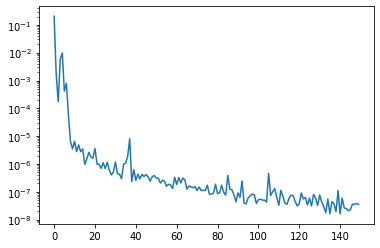

In [ ]:
# Train Network
net_adam.learn(train_dl, epochs=150, optimizer=optim, loss_fcn=loss_fcn)
torch.save(net_adam.to('cpu'), f'{BASE_DIR}/vgg11_trained.pt')

# Resnet 50

In [ ]:
def train_model(model, criterion, optimizer, train_dl, scheduler=None, num_epochs=25):
    # Training Mode
    model.train()
    losses = []
    accuracies = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        running_corrects = 0

        for x_train, t_train in train_dl:
          inputs = x_train.to(device)
          labels = t_train.to(device)
          
          # Setup for Backprop
          optimizer.zero_grad()
          
          # Backprop
          with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
          
            # Bookkeeping
            running_loss += loss.item() * len(inputs)
            running_corrects += torch.sum(preds == labels)

        # If scheduler provided step scheduler
        if scheduler is not None:
          scheduler.step()

        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects / len(train_dl.dataset)

        # Bookkepping
        losses.append(epoch_loss)
        accuracies.append(epoch_acc.item())

    # Plot Training Losses
    plt.subplot(1, 2, 1)
    plt.plot(losses); plt.yscale('log');
    plt.ylabel('Training Loss')
    plt.xlabel('Epoch')

    # Plot Training Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.ylabel('Training Accuracy')
    plt.xlabel('Epoch')

    # Testing Mode
    model.eval()

In [ ]:
# Use Resnet-50 Pre-Trained Model From PyTorch
# model_ft = torchvision.models.resnet50(pretrained=True)
model_ft = torchvision.models.resnet152(pretrained=False)

# Modifying final layer to make it predict for our 22 classes (now 2 classes)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
model_ft.train()

# Best for Image Classification Tasks
criterion = nn.CrossEntropyLoss()

# Choose one of the following optimizers
# optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = None #torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


100%|██████████| 45/45 [02:41<00:00,  3.59s/it]


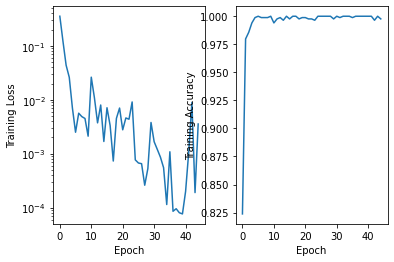

In [ ]:
train_model(model_ft, criterion, optimizer_ft, train_dl, scheduler=exp_lr_scheduler, num_epochs=45)

# Save Resnet-50 Trained Model

In [ ]:
# Save Model
torch.save(model_ft.to('cpu'), f'{BASE_DIR}/resnet_50_trained.pt')
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 